## Taxi Trip Duration
1. Frame the problem and look at the big picture
2. Get the data
3. Explore the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models and combine them into a great solution
7. Present your solution
8. Launch, monitor and maintain your system


## Frame the problem and look at the big picture

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. 
In this project the goal is to make a model based on individual trip attributes, to be able to predict the duration of each trip in the test set.


## Get the data

In [1]:
# get data for dataset

# Common imports
import numpy as np
import os
# to make this notebook's output stable across runs
np.random.seed(42)
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import os
import tarfile
from six.moves import urllib

TAXI_PATH = os.path.join("data", "taxi")

def load_taxi_data(taxi_path=TAXI_PATH):
    csv_path = os.path.join(taxi_path, "train.csv")
    return pd.read_csv(csv_path)

import warnings
warnings.filterwarnings(action="ignore", message="^RuntimeWarning")

In [2]:
train = load_taxi_data()
csv_path = os.path.join(TAXI_PATH, "test.csv")
test = pd.read_csv(csv_path)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Explore the data to gain insights - visualising the data

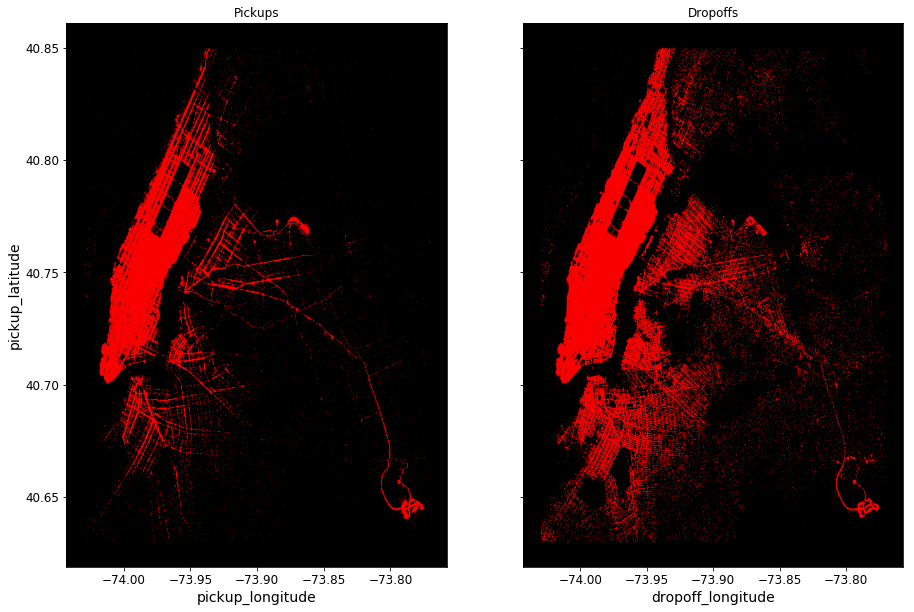

In [3]:
west, south, east, north = -74.03, 40.63, -73.77, 40.85

train = train[(train.pickup_latitude > south) & (train.pickup_latitude < north)]
train = train[(train.dropoff_latitude > south) & (train.dropoff_latitude < north)]
train = train[(train.pickup_longitude > west) & (train.pickup_longitude < east)]
train = train[(train.dropoff_longitude > west) & (train.dropoff_longitude < east)]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(15,10))

train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='red', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Pickups")
ax1.set_facecolor('black')

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='red', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Dropoffs")
ax2.set_facecolor('black') 



As we can se in the above map - most of the journeys have been from and to manhattan.
There are two airports, John F. Kennedy and LA Guardia Airport in queens which has a good amount of taxi trips from and too. 
When calculating the euclidean distance the distance will be hugely afftected by the taxi trips that start in manhattan and ends outside.


## Viewing the pickups and dropoffs of trips in folium

In [4]:
import folium 

newyork_map = folium.Map(location=[40.767937,-73.982155 ], tiles='OpenStreetMap', zoom_start=12)

def createMap(geo_map, data, i=100):
    for each in train[:i].iterrows():
        p1 = [each[1]['pickup_latitude'] ,each[1]['pickup_longitude']]
        p2 = [each[1]['dropoff_latitude'], each[1]['dropoff_longitude']]
        folium.CircleMarker(p1,
                            radius=3,
                            color='blue',
                            popup=str(each[1]['pickup_latitude'])+','+str(each[1]['pickup_longitude']),
                            fill_color='#FD8A6C'
                            ).add_to(geo_map)
        folium.CircleMarker(p2,
                            radius=3,
                            color='red',
                            popup=str(each[1]['dropoff_latitude'])+','+str(each[1]['dropoff_longitude']),
                            fill_color='#FD8A6C'
                            ).add_to(geo_map)
        folium.PolyLine(locations=[p1, p2], color='green').add_to(geo_map)
    
createMap(newyork_map, train)

newyork_map

In [5]:
def manh_checker(x):
    return 40.7091 < x['dropoff_latitude'] < 40.8205 and \
    -74.0096 < x['dropoff_longitude'] < -73.9307 and \
    40.7091 < x['pickup_latitude'] < 40.8205 and \
    -74.0096 < x['pickup_longitude'] < -73.9307
   
#test = train.apply(manh_checker, axis = 1) 
#print(test.sum()*100 / len(train))

So 80% of all journeys start and end in (or slighlty around) Manhattan island. So calculating the manhattan distance can give a better estimate of the distance. 

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00,1438626.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,945.99
std,0.50,1.31,0.04,0.03,0.03,0.03,5252.16
min,1.00,0.00,-74.03,40.63,-74.03,40.63,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,394.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,656.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1059.00
max,2.00,6.00,-73.77,40.85,-73.77,40.85,3526282.00


In [7]:
#durations_longer_than_4timer = train.query("trip_duration > 10800").groupby(["trip_duration"]).size()
#long_durations = pd.DataFrame({'id'}:durations_longer_than_4timer))

1. Looking at count of all columns, we can conclude we have have no missing values.
2. There is an outlier where the passenger count is 0. We need to remove that.
3. There is also a minimum trip duration of 1 second, those trips are going nowhere and the maximum is 35,26,282 seconds.
The outliers needs to be removed. 

In [8]:
test.isnull().sum(axis=0).sum(axis=0)

0

In [9]:
train.isnull().sum(axis=0).sum(axis=0)

0

There are no missing values.

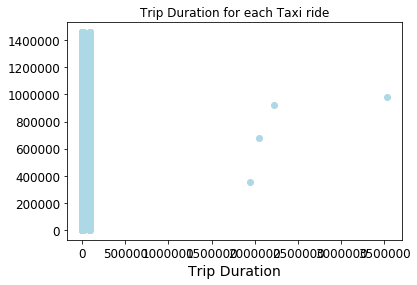

In [10]:
plt.scatter(train.trip_duration,train.index,color="lightblue")
plt.xlabel("Trip Duration")
plt.title("Trip Duration for each Taxi ride");

Looks like some trips are going too far away from New York city(Long rides who knows). These are outliers. Since the evaluation metrics is RMSLE(Root Mean Squared Logarithmic Error), we can log transform trip duration and use RMSE(Root Mean Squared Error) for training. So that outliers won't affect model performance much. Don't forget to take exponential of it while submitting submission file.

In [11]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)

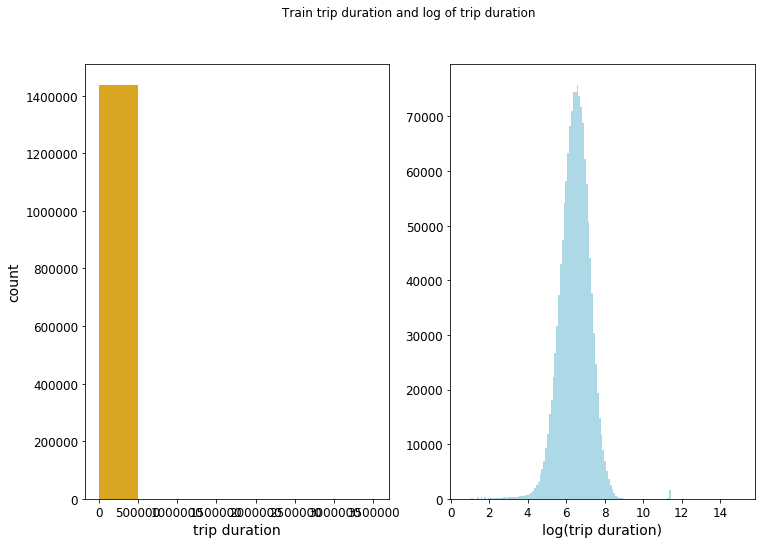

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,8))
fig.suptitle('Train trip duration and log of trip duration')
ax1.set_ylabel('count')
ax1.set_xlabel('trip duration')
ax2.set_xlabel('log(trip duration)')
ax1.hist(train.trip_duration,bins=7, color="goldenrod")
ax2.hist(train.log_trip_duration,bins=150, color="lightblue");

In [13]:
print("Skewness: %f" % train['log_trip_duration'].skew())
print("Kurtosis: %f" % train['log_trip_duration'].kurt())

Skewness: -0.265401
Kurtosis: 3.881358


1. Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.
2. Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers. Data sets with low kurtosis tend to have light tails, or lack of outliers. A uniform distribution would be the extreme case. 

From what we can see in the histogram to the left there are some points that falls outside the bellcurve. These are the outliers I mentioned earlier.  


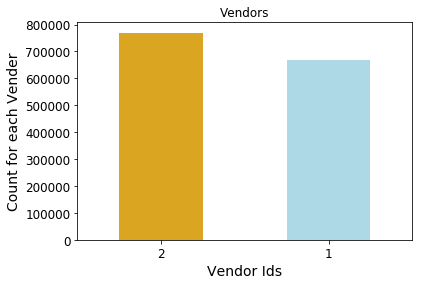

In [14]:
train["vendor_id"].value_counts().plot(kind='bar',color=["goldenrod","lightblue"])
plt.xticks(rotation='horizontal')
plt.title("Vendors")
plt.ylabel("Count for each Vender")
plt.xlabel("Vendor Ids");

Only 2 Vendors are there, they can be representing 2 taxi companies. Vendor 2 has more share in taxi rides in New York city. 

How many passengers are traveling together?

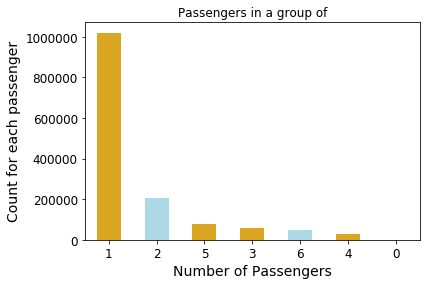

In [15]:
train["passenger_count"].value_counts().plot(kind='bar',color=["goldenrod","lightblue"])
plt.title("Passengers in a group of")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for each passenger")
plt.xlabel("Number of Passengers");

Most popular choice of travel is single.
2nd popular way of ride is with a single friend.
May be for long cars popular choice of travel is in group of 5 and then in group of 6 people.

In [16]:
train.groupby('passenger_count').size()

passenger_count
0         53
1    1019547
2     207083
3      59086
4      28001
5      77100
6      47756
dtype: int64

In [17]:
test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

There are some outliners here. We have 53 and 23 trips with zero passengers. There is also two trips with 9 passengers. 
Other than that the data seems to match relatively between the two data sets.

### Passenger count vs trip_duration


No handles with labels found to put in legend.


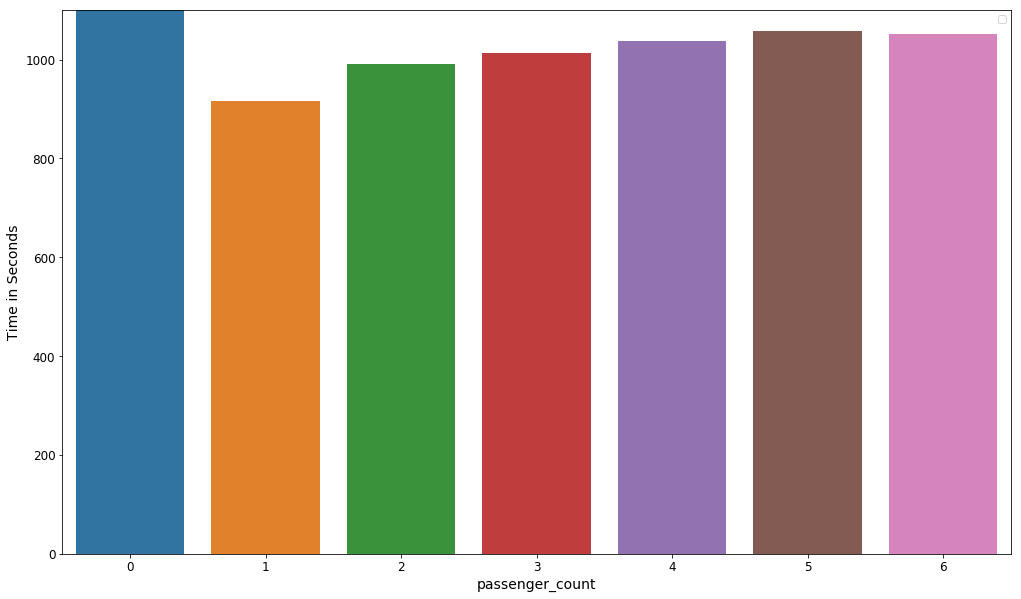

In [18]:
pc = train.groupby('passenger_count')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)


The time goes slightly up with the number of passenger increasing but nothing significant. Which is interesting because the more passengers the more stops. Unless they are all going to the same place.   

## Whether the Trip Details are Stored Or Forwarded?

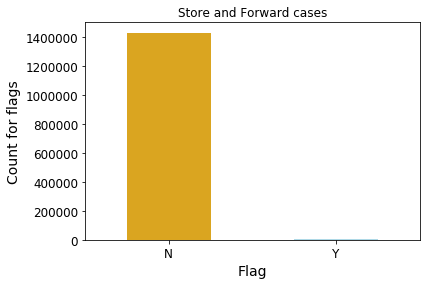

In [19]:
train["store_and_fwd_flag"].value_counts().plot(kind='bar', color=["goldenrod","lightblue"])
plt.title("Store and Forward cases")
plt.xticks(rotation='horizontal')
plt.ylabel("Count for flags")
plt.xlabel("Flag");

Almost all the journey details were immediately sent to vendors. Very few stored in device memory may be due to bad signal or bad weather.


## Feature Engineering

How about Dates and timings of the trips? - our temporal friends

We can extract lot of insights from dates and time data we have.

1. Pickup hour rushes can define start of office timings and drop offs in evening can tell till what time New Yorkers work.
2. Weekdays and weekends can show another angle of city life. Weekends people will be getting up late and starting day late compared to weekdays. Also parties can go beyond midnight hours on weekends.
3. We can also look out for some kind of seasonality. For example, during winter seasons traffic will be going slow due to snowfalls or wetness on Roads. So, trip Duration will be longer in winters than other seasons.


### Dropping zero passengers.

In [20]:
train = train[train.passenger_count != 0]
test = test[test.passenger_count != 0]
test = test[test.passenger_count != 9]

In [21]:
train = train[train.trip_duration != 0]
len(train.index)

1438573

### Date Extraction
Extraction out the date time to multiple variables enables us to do one hot encoding. Ml models understands 0's and 1's istead of januar and februar
Also by doing this we can get a better understanding of for example a given hour if it is rush or not

In [22]:
#time train

train['pickup_datetime']             = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime']            = pd.to_datetime(train.dropoff_datetime) # Not in Test

train['pickup_weekday']              = pd.to_datetime(train.pickup_datetime).dt.dayofweek.astype('uint8')
train['pickup_day']                  = pd.to_datetime(train.pickup_datetime).dt.day.astype('uint8')
train['pickup_hour']                 = pd.to_datetime(train.pickup_datetime).dt.hour.astype('uint8')
train['pickup_minute']               = pd.to_datetime(train.pickup_datetime).dt.minute.astype('uint8')
train['pickup_second']               = pd.to_datetime(train.pickup_datetime).dt.second.astype('uint8')
train["pickup_dayofyear"]            = pd.to_datetime(train.pickup_datetime).dt.dayofyear.astype('uint8')
train['pickup_month']                = pd.to_datetime(train.pickup_datetime).dt.month.astype('uint8')

train['pickup_dt']                   = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
train['pickup_week_hour']            = train['pickup_weekday'] * 24 + train['pickup_hour']

In [23]:
# time test 

test['pickup_datetime']              = pd.to_datetime(test.pickup_datetime)

test['pickup_weekday']               = pd.to_datetime(test.pickup_datetime).dt.dayofweek.astype('uint8')
test['pickup_day']                   = pd.to_datetime(test.pickup_datetime).dt.day.astype('uint8')
test['pickup_hour']                  = pd.to_datetime(test.pickup_datetime).dt.hour.astype('uint8')
test['pickup_minute']                = pd.to_datetime(test.pickup_datetime).dt.minute.astype('uint8')
test['pickup_second']                = pd.to_datetime(test.pickup_datetime).dt.second.astype('uint8')
test["pickup_dayofyear"]             = pd.to_datetime(test.pickup_datetime).dt.dayofyear.astype('uint8')
test['pickup_month']                 = pd.to_datetime(test.pickup_datetime).dt.month.astype('uint8')

test['pickup_dt']                    = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test['pickup_week_hour']             = test['pickup_weekday'] * 24 + test['pickup_hour']

## SHOW TIME GRAPHS

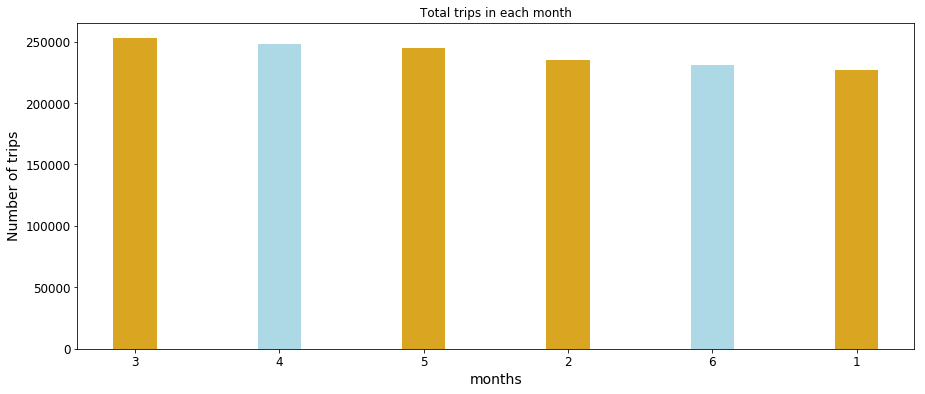

In [24]:
plt.figure(figsize=(15, 6)) 
train.pickup_month.value_counts().plot(kind='bar',color=["goldenrod","lightblue"],align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("months")
plt.ylabel("Number of trips")
plt.title("Total trips in each month");


We have data from January to June of 2016. Highest number of trips happened in March and lowest in January.

## Month and Trip Durations Together with Vendor Contribution

Since we have kernel memory limit , I have taken subset of data

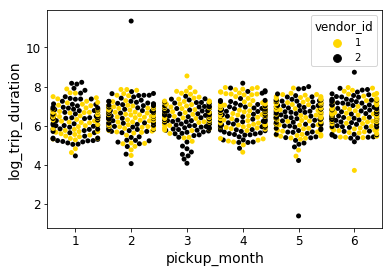

In [25]:
sns.swarmplot(train.pickup_month[:1000],train.log_trip_duration[:1000],hue=train.vendor_id[:1000],palette={1:'gold',2:'black'});

There is nothing dishtinguishable here, few outliers here and there. Vendors contribution is apporoximately same. There is linear relationship between Month and Trip Duration.

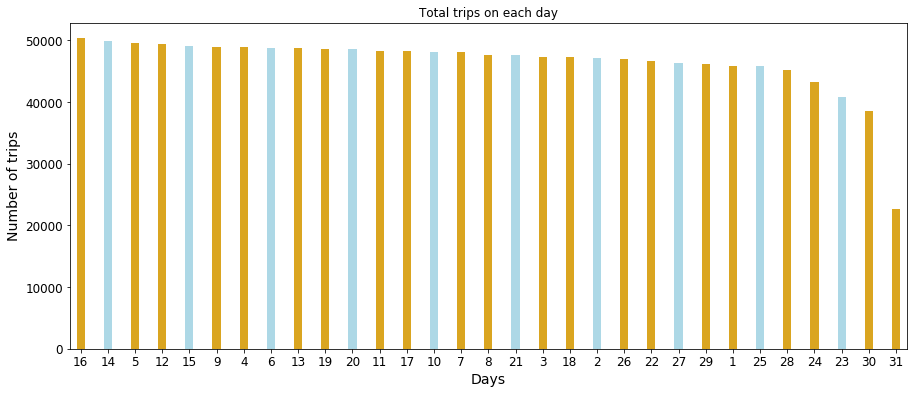

In [26]:
plt.figure(figsize=(15, 6)) 
train.pickup_day.value_counts().plot(kind='bar',color=["goldenrod","lightblue"],align='center',width=0.3)
plt.xlabel("Days")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total trips on each day");

1. Highest number of trips happened on 16th of the month while lowest on 31st.
2. 30th and 31st have less trips because we have 6 months data and 30th and 31st came only 3 times each.



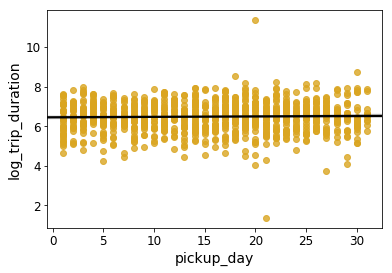

In [27]:
sns.regplot(train.pickup_day[:1000],train.log_trip_duration[:1000],color='goldenrod', line_kws={'color':'black'});

The median of trip duration is approximately 6.48. There is clearly linear relationship between these two. Hmm!! The solid black line depicts linear regression model fit.

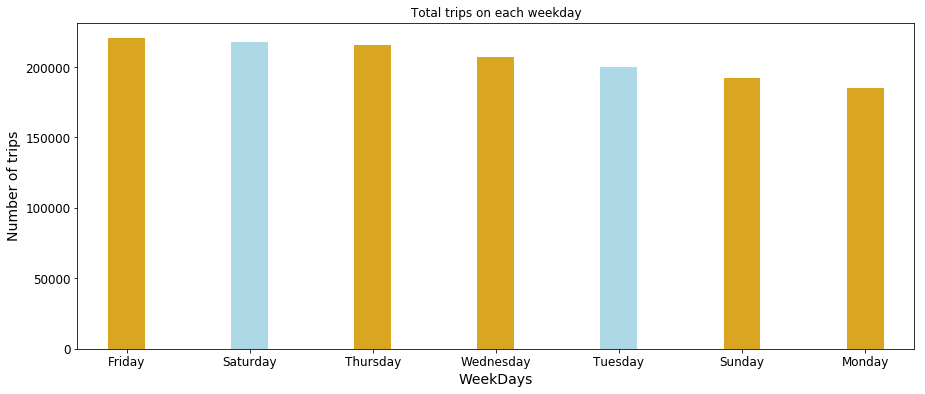

In [28]:
train['pickup_weekday_name'] = train['pickup_datetime'].dt.weekday_name
plt.figure(figsize=(15, 6)) 
train.pickup_weekday_name.value_counts().plot(kind='bar',color=["goldenrod","lightblue"],align='center',width=0.3)
plt.xlabel("WeekDays")
plt.xticks(rotation='horizontal')
plt.ylabel("Number of trips")
plt.title("Total trips on each weekday");
train.drop('pickup_weekday_name',axis=1,inplace=True)

Highest number of trips took place on every Friday of the week while lowest on Mondays. (Monday blues :() Thursday and Saturday were also busy days.

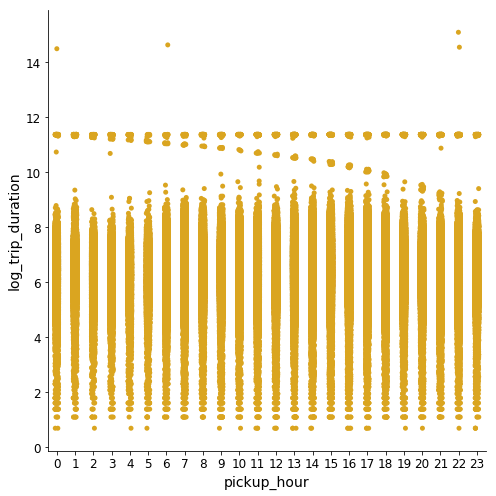

In [29]:
sns.catplot(x="pickup_hour", y="log_trip_duration", data=train,color='goldenrod',height=7);

## Taxi Trips By Dropoff Hour

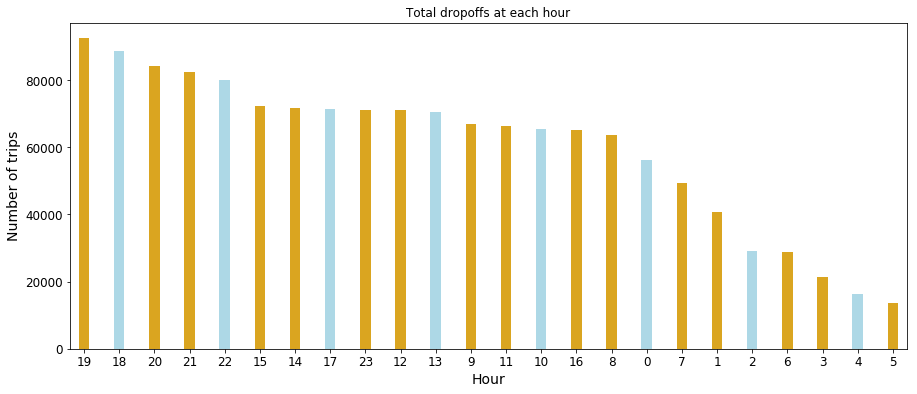

In [30]:

train['dropoff_hour'] = train['dropoff_datetime'].dt.hour
plt.figure(figsize=(15, 6)) 
train.dropoff_hour.value_counts().plot(kind='bar',color=["goldenrod","lightblue"],align='center',width=0.3)
plt.xticks(rotation='horizontal')
plt.xlabel("Hour")
plt.ylabel("Number of trips")
plt.title("Total dropoffs at each hour");
train.drop('dropoff_hour',axis=1,inplace=True)



/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


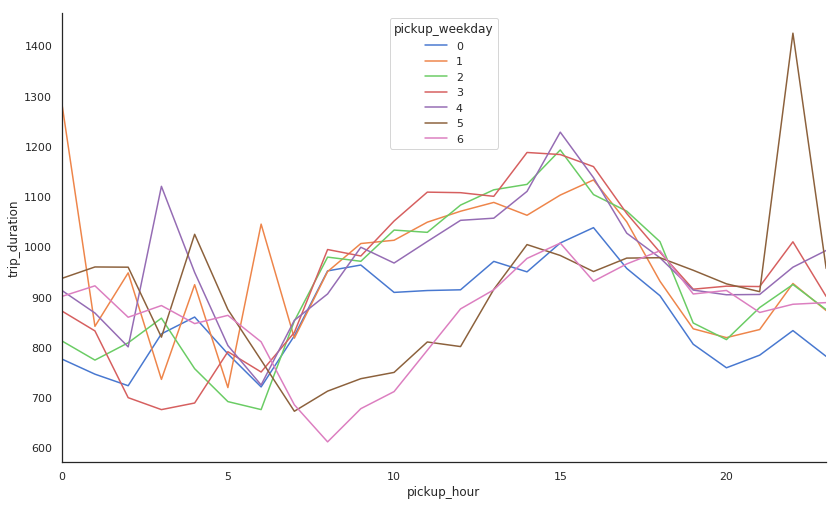

In [31]:
summary_hour_duration = pd.DataFrame(train.groupby(['pickup_weekday','pickup_hour'])['trip_duration'].mean())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False, rc={'figure.figsize':(13.7,8.27)})
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="pickup_weekday", value="trip_duration")
sns.despine(bottom = False)

Convert storea and forward flag.

In [32]:

train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')


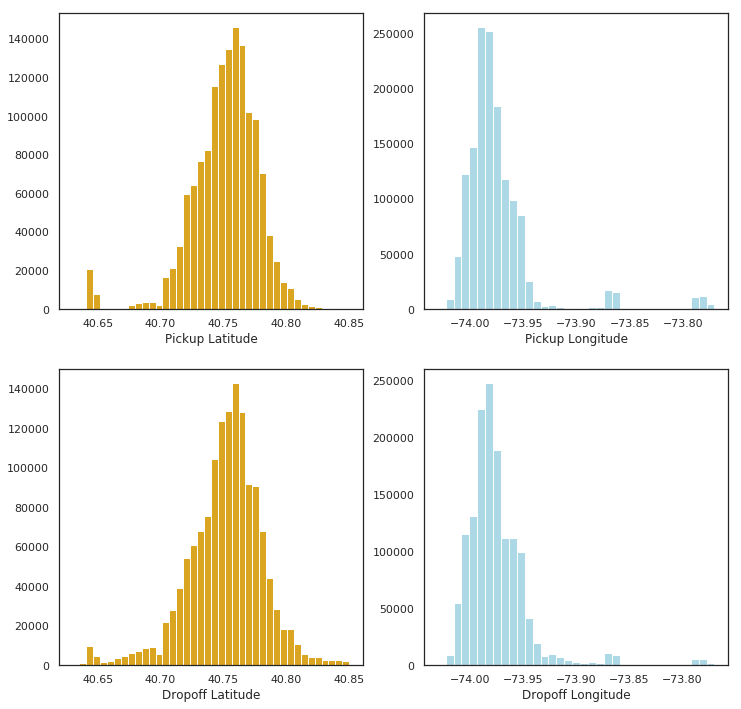

In [33]:


fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(12, 12), sharex=False, sharey = False)
ax[0,0].hist(train.pickup_latitude.values,bins=40,color="goldenrod")
ax[0,1].hist(train.pickup_longitude.values,bins=35,color="lightblue")
ax[1,0].hist(train.dropoff_latitude.values,bins=40,color="goldenrod")
ax[1,1].hist(train.dropoff_longitude.values,bins=35,color="lightblue")
ax[0,0].set_xlabel('Pickup Latitude')
ax[0,1].set_xlabel('Pickup Longitude')
ax[1,0].set_xlabel('Dropoff Latitude')
ax[1,1].set_xlabel('Dropoff Longitude');



## Calculate Distance and Speed

distances have been calculated and put into a csv files

In [34]:
TAXI_PATH = os.path.join("data", "taxi")
csv_path = os.path.join(TAXI_PATH, "train_distance.csv")
train_distance = pd.read_csv(csv_path, index_col=0)

csv_path = os.path.join(TAXI_PATH, "test_distance.csv")
test_distance = pd.read_csv(csv_path, index_col=0)
train.isnull().sum(axis=0).sum(axis=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


0

In [35]:
train = train.join(train_distance.set_index('id'), on='id')
test = test.join(test_distance.set_index('id'), on='id')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_second,pickup_dayofyear,pickup_month,pickup_dt,pickup_week_hour,haversine_distance,euclidean_distance,log_euclidean_distance,manhattan_distance,log_manhattan_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,0,...,55,74,3,6369878.00,17,1.50,0.02,0.02,1.74,1.01
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,0,...,35,164,6,14085798.00,144,1.81,0.02,0.02,2.43,1.23
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,0,...,24,19,1,1596907.00,35,6.39,0.06,0.06,8.20,2.22
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,0,...,31,97,4,8364734.00,67,1.49,0.01,0.01,1.66,0.98
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,0,...,55,86,3,7392638.00,133,1.19,0.01,0.01,1.20,0.79


In [36]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_weekday,...,pickup_second,pickup_dayofyear,pickup_month,pickup_dt,pickup_week_hour,haversine_distance,euclidean_distance,log_euclidean_distance,manhattan_distance,log_manhattan_distance
0,id3004672,1,2016-06-30 23:59:58,1,-73.99,40.73,-73.99,40.76,0,3,...,58,182,6,15724781.00,95,2.75,0.02,0.02,2.91,1.36
1,id3505355,1,2016-06-30 23:59:53,1,-73.96,40.68,-73.96,40.66,0,3,...,53,182,6,15724776.00,95,2.76,0.02,0.02,3.10,1.41
2,id1217141,1,2016-06-30 23:59:47,1,-74.00,40.74,-73.99,40.73,0,3,...,47,182,6,15724770.00,95,1.31,0.01,0.01,1.85,1.05
3,id2150126,2,2016-06-30 23:59:41,1,-73.96,40.77,-73.99,40.73,0,3,...,41,182,6,15724764.00,95,5.27,0.05,0.05,7.16,2.10
4,id1598245,1,2016-06-30 23:59:33,1,-73.97,40.76,-73.96,40.76,0,3,...,33,182,6,15724756.00,95,0.96,0.01,0.01,1.35,0.86


## Speed

In [37]:
train.loc[:, 'avg_speed_h'] = 1000 * train['haversine_distance'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['manhattan_distance'] / train['trip_duration']
train.loc[:, 'avg_speed_eu'] = 1000 * train['euclidean_distance'] / train['trip_duration']

test.loc[:, 'avg_speed_h'] = 1000 * test['haversine_distance'] / train['trip_duration']
test.loc[:, 'avg_speed_m'] = 1000 * test['manhattan_distance'] / train['trip_duration']
test.loc[:, 'avg_speed_eu'] = 1000 * test['euclidean_distance'] / train['trip_duration']
train.isnull().sum(axis=0).sum(axis=0)

0

In [38]:
test.isnull().sum(axis=0).sum(axis=0)

25854

In [39]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_dt,pickup_week_hour,haversine_distance,euclidean_distance,log_euclidean_distance,manhattan_distance,log_manhattan_distance,avg_speed_h,avg_speed_m,avg_speed_eu
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,0,...,6369878.00,17,1.50,0.02,0.02,1.74,1.01,3.29,3.81,0.04
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,0,...,14085798.00,144,1.81,0.02,0.02,2.43,1.23,2.72,3.67,0.03
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,0,...,1596907.00,35,6.39,0.06,0.06,8.20,2.22,3.01,3.86,0.03
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,0,...,8364734.00,67,1.49,0.01,0.01,1.66,0.98,3.46,3.87,0.03
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,0,...,7392638.00,133,1.19,0.01,0.01,1.20,0.79,2.73,2.76,0.02


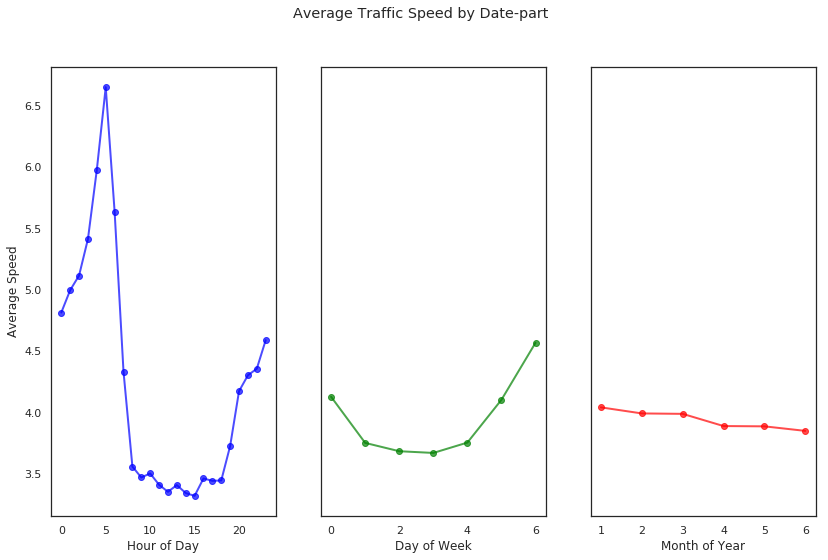

In [40]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

most of the travelling in the Big Apple happens during work hours. The average speed by weekday follows an expected trend. Over the weekend (Friday, Saturday, Sunday) the average speed picks up quite nicely, indicating less traffic. Finally, the average trip speed by month follows an expected trend. In the winter months there are less trips (see the previous timeseries plot we made) indicating less traffic in general in the city which means you can average a higher speed on the roads.

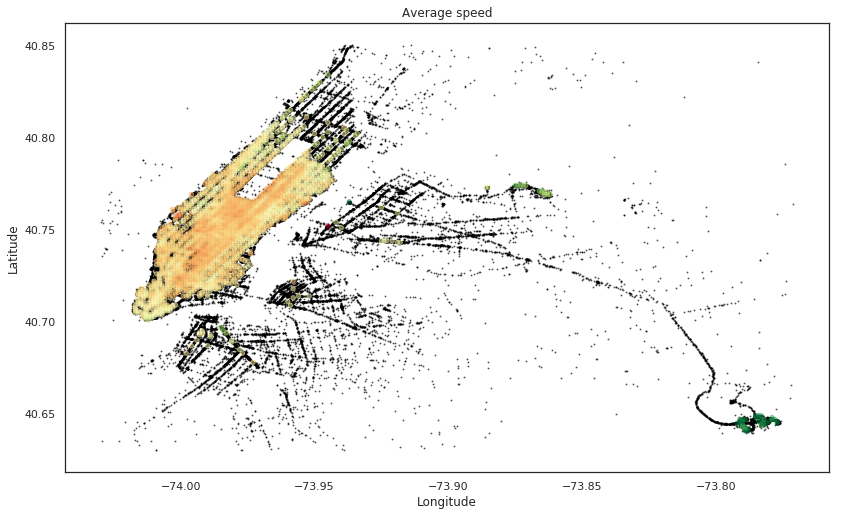

In [41]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()



In [42]:
test.isnull().sum(axis=0).sum(axis=0)

25854

In [43]:
train.isnull().sum(axis=0).sum(axis=0)

0

## Calculate the fastest route
I have downloaded a osrm http://project-osrm.org/ fastest route csv file from all the locations.

In [44]:
TAXI_PATH = os.path.join("data", "taxi")
csv_path_part1 = os.path.join(TAXI_PATH, "fastest_routes_train_part_1.csv")
csv_path_part2 = os.path.join(TAXI_PATH, "fastest_routes_train_part_2.csv")
csv_path_test = os.path.join(TAXI_PATH, "fastest_routes_test.csv")
cols = ['id', 'total_distance', 'total_travel_time',  'number_of_steps']

fastest_routes1 = pd.read_csv(csv_path_part1, usecols = cols)
fastest_routes2 = pd.read_csv(csv_path_part2, usecols = cols)
test_fastest_routes = pd.read_csv(csv_path_test, usecols = cols)

train_fastest_routes = pd.concat((fastest_routes1, fastest_routes2))

train = train.merge(train_fastest_routes, how='left', on='id')
test = test.merge(test_fastest_routes, how='left', on='id')

In [45]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,manhattan_distance,log_manhattan_distance,avg_speed_h,avg_speed_m,avg_speed_eu,pickup_lat_bin,pickup_long_bin,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,0,...,1.74,1.01,3.29,3.81,0.04,40.77,-73.98,2009.10,164.90,5.00
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,0,...,2.43,1.23,2.72,3.67,0.03,40.74,-73.98,2513.20,332.00,6.00
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,0,...,8.20,2.22,3.01,3.86,0.03,40.76,-73.98,11060.80,767.60,16.00
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,0,...,1.66,0.98,3.46,3.87,0.03,40.72,-74.01,1779.40,235.80,4.00
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,0,...,1.20,0.79,2.73,2.76,0.02,40.79,-73.97,1614.90,140.10,5.00


In [46]:
train.isnull().sum(axis=0).sum(axis=0)

3

In [47]:
test.isnull().sum(axis=0).sum(axis=0)

25854

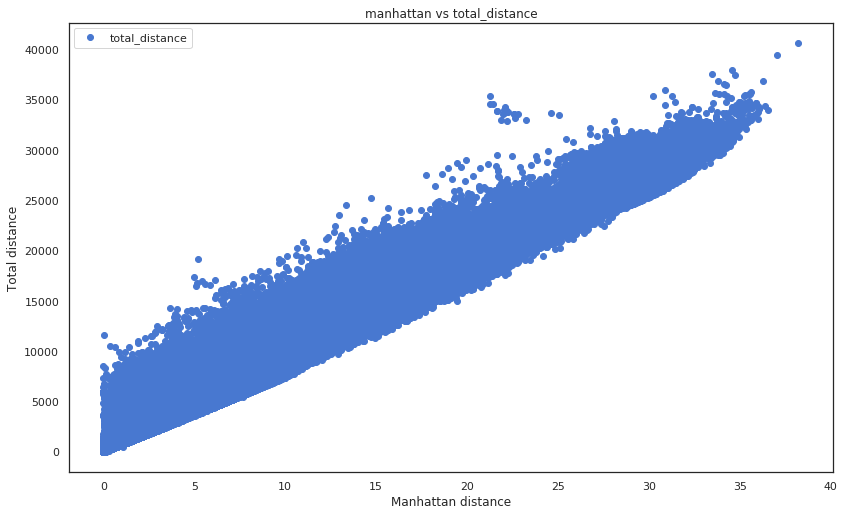

In [48]:
train.plot(x='manhattan_distance', y='total_distance', style='o')  
plt.title('manhattan vs total_distance')  
plt.xlabel('Manhattan distance')  
plt.ylabel('Total distance')  
plt.show()  

## Model and prediction 

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [76]:
train_samples = train
target = train_samples.log_trip_duration.values
train_samples = train_samples.drop(['id', 'pickup_datetime', 'haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu','dropoff_datetime', 'trip_duration','log_trip_duration','pickup_dt'], axis=1)
train_samples.fillna(0,inplace=True)

In [51]:
test_samples = test.sample(n=round(0.10*len(test.index)))
Id=test.id.values
test_samples = test_samples.drop(['id','pickup_datetime','pickup_dt','haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu'], axis=1)
test.fillna(0,inplace=True)
predictors=test_samples.columns

In [52]:
feature_names = list(train_samples.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(test_samples.columns, train_samples.columns)))
print("")
do_not_use_for_training = ['id', 'pickup_datetime', 'haversine_distance', 'manhattan_distance','euclidean_distance','avg_speed_h','avg_speed_m','avg_speed_eu','dropoff_datetime', 'trip_duration','log_trip_duration','pickup_dt']
feature_names = [f for f in test_samples.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))


Difference of features in train and test are []

We will be using following features for training ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_weekday', 'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_second', 'pickup_dayofyear', 'pickup_month', 'pickup_week_hour', 'log_euclidean_distance', 'log_manhattan_distance', 'total_distance', 'total_travel_time', 'number_of_steps'].

Total number of features are 20.


In [53]:
### split to train and validationset

In [79]:
X_train, X_test, y_train, y_test = train_test_split(train_samples, target, random_state=42, test_size = 0.2)

In [55]:
rf_clf = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42, n_jobs=-1)
rf_clf.fit(X_train.values, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [56]:
rf_clf.score(X_test, y_test)

0.730896970026178

In [57]:
importances = rf_clf.feature_importances_

In [58]:
indices = np.argsort(importances)[::-1]

In [59]:
for f in range(10): 
    print(f'{X_train.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

total_distance: 0.53
total_travel_time: 0.13
pickup_hour: 0.05
log_euclidean_distance: 0.04
dropoff_latitude: 0.04
dropoff_longitude: 0.02
log_manhattan_distance: 0.02
pickup_week_hour: 0.02
pickup_dayofyear: 0.02
pickup_minute: 0.02


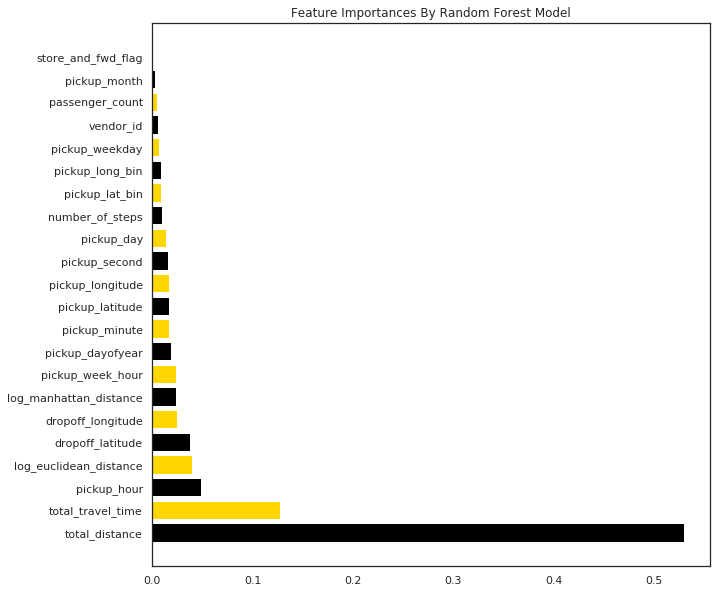

In [60]:
predictors=train_samples.columns
importances=rf_clf.feature_importances_
std = np.std([rf_clf.feature_importances_ for tree in rf_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
plt.figure(figsize=(10,10))
plt.title("Feature Importances By Random Forest Model")
plt.barh(range(len(indices)), importances[indices],
       color=["goldenrod","lightblue"], yerr=std[indices], align="center")
plt.yticks(range(len(indices)), sorted_important_features, rotation='horizontal');

### creating a pipeline

In [62]:
steps = [("ohe_onestep", DictVectorizer(sparse = False)), ("xgb_model", xgb.XGBRegressor())]

In [63]:
xgb_pipeline = Pipeline(steps)

In [64]:
final_predictions = rf_clf.predict(X_test)

### final scores

In [66]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

0.411782267860921


### testing with xgboost

In [80]:

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_pars = {'min_child_weight': 80, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 25,
            'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

# You could try to train with more epoch
model = xgb.train(xgb_pars, dtrain, 20, watchlist, early_stopping_rounds=5,
                  maximize=False, verbose_eval=1)


print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.22711	valid-rmse:4.2256
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 5 rounds.
[1]	train-rmse:2.97609	valid-rmse:2.97448
[2]	train-rmse:2.10622	valid-rmse:2.1048
[3]	train-rmse:1.51018	valid-rmse:1.50897
[4]	train-rmse:1.09904	valid-rmse:1.09863
[5]	train-rmse:0.822178	valid-rmse:0.82324
[6]	train-rmse:0.642725	valid-rmse:0.645985
[7]	train-rmse:0.528052	valid-rmse:0.535219
[8]	train-rmse:0.456795	valid-rmse:0.468388
[9]	train-rmse:0.415831	valid-rmse:0.431859
[10]	train-rmse:0.39191	valid-rmse:0.412268
[11]	train-rmse:0.377695	valid-rmse:0.401112
[12]	train-rmse:0.368097	valid-rmse:0.395195
[13]	train-rmse:0.361251	valid-rmse:0.391523
[14]	train-rmse:0.355914	valid-rmse:0.389756
[15]	train-rmse:0.351826	valid-rmse:0.388734
[16]	train-rmse:0.349156	valid-rmse:0.388396
[17]	train-rmse:0.346459	valid-rmse:0.388001
[18]	train-rmse:0.343207	valid-rmse:0.387395
[19]	train-rmse:0.340368	

### submission

In [69]:
predictions=rf_clf.predict(test_samples.values)
predictions[:5]

ValueError: Number of features of the model must match the input. Model n_features is 22 and input n_features is 20 

In [ ]:
test['trip_duration'] = np.exp(predictions) - 1
test['id']=Id
test[['id', 'trip_duration']].to_csv('poonam.csv.gz', index=False, compression='gzip')
test['trip_duration'][:5]